# Expedia Hotel Ranking Problem

## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

## Import Datasets
Read training and testing datasets and parse the date to integers, as this will be useful for the algorithm, otherwise it will be interpreted as a categorical variable.

In [2]:
data = pd.read_csv('training_set_VU_DM.csv', nrows=10000)
data["date_time"] = pd.to_datetime(data.date_time)
data["integer_time"] = data['date_time'].dt.strftime("%Y%m%d%H%M%S")
data.integer_time = pd.to_numeric(data.integer_time, errors='coerce')

testingData = pd.read_csv('test_set_VU_DM.csv', nrows=10000)
testingData["date_time"] = pd.to_datetime(testingData.date_time)
testingData["integer_time"] = testingData['date_time'].dt.strftime("%Y%m%d%H%M%S")
testingData.integer_time = pd.to_numeric(testingData.integer_time, errors='coerce')

## EDA
Look for Null Values

In [3]:
{column: data[column].isnull().sum() for column in data.columns if data[column].isnull().sum() > 0}

{'visitor_hist_starrating': 9503,
 'visitor_hist_adr_usd': 9503,
 'prop_review_score': 17,
 'prop_location_score2': 2269,
 'srch_query_affinity_score': 9460,
 'orig_destination_distance': 3204,
 'comp1_rate': 9732,
 'comp1_inv': 9700,
 'comp1_rate_percent_diff': 9781,
 'comp2_rate': 5858,
 'comp2_inv': 5700,
 'comp2_rate_percent_diff': 8873,
 'comp3_rate': 6775,
 'comp3_inv': 6560,
 'comp3_rate_percent_diff': 9066,
 'comp4_rate': 9323,
 'comp4_inv': 9261,
 'comp4_rate_percent_diff': 9745,
 'comp5_rate': 5062,
 'comp5_inv': 4831,
 'comp5_rate_percent_diff': 8159,
 'comp6_rate': 9347,
 'comp6_inv': 9297,
 'comp6_rate_percent_diff': 9741,
 'comp7_rate': 9217,
 'comp7_inv': 9081,
 'comp7_rate_percent_diff': 9638,
 'comp8_rate': 5940,
 'comp8_inv': 5811,
 'comp8_rate_percent_diff': 8725,
 'gross_bookings_usd': 9719}

In [4]:
{column: testingData[column].isnull().sum() for column in testingData.columns if testingData[column].isnull().sum() > 0}

{'visitor_hist_starrating': 9381,
 'visitor_hist_adr_usd': 9381,
 'prop_review_score': 15,
 'prop_location_score2': 2404,
 'srch_query_affinity_score': 9512,
 'orig_destination_distance': 3581,
 'comp1_rate': 9806,
 'comp1_inv': 9802,
 'comp1_rate_percent_diff': 9854,
 'comp2_rate': 5725,
 'comp2_inv': 5495,
 'comp2_rate_percent_diff': 8869,
 'comp3_rate': 6630,
 'comp3_inv': 6400,
 'comp3_rate_percent_diff': 8945,
 'comp4_rate': 9331,
 'comp4_inv': 9247,
 'comp4_rate_percent_diff': 9710,
 'comp5_rate': 5406,
 'comp5_inv': 5152,
 'comp5_rate_percent_diff': 8181,
 'comp6_rate': 9484,
 'comp6_inv': 9425,
 'comp6_rate_percent_diff': 9761,
 'comp7_rate': 9290,
 'comp7_inv': 9211,
 'comp7_rate_percent_diff': 9646,
 'comp8_rate': 6048,
 'comp8_inv': 5891,
 'comp8_rate_percent_diff': 8759}

As the number of null values in `srch_visitor_wr_member`, `srch_posa_continent` and `srch_currency` are very high, these columns can be removed. Furthermore, it is not necessary to have the local currency columns for discount and non-discount prices, becuase this is just a transformation and having everything in usd is better. So `prop_price_without_discount_local` and `prop_price_with_discount_local` can also be removed.

In [5]:
data.drop(["date_time"], axis=1, inplace=True)

In [6]:
testingData.drop(["date_time"], axis=1, inplace=True)

Remaining Columns

In [7]:
data.columns

Index(['srch_id', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv'

## Data Summary

In [8]:
data.describe()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,integer_time
count,10000.000000,10000.000000,10000.000000,497.000000,497.000000,10000.000000,10000.000000,10000.000000,9983.000000,10000.000000,...,783.000000,919.000000,362.000000,4060.000000,4189.000000,1275.000000,10000.000000,281.000000,10000.000000,1.000000e+04
mean,353.842700,9.949100,172.925600,3.261247,176.708068,171.329500,69987.360100,3.169400,3.782330,0.625200,...,0.189017,0.095756,21.662983,-0.058867,0.008355,14.184314,0.045700,409.795516,0.028100,2.012835e+13
std,204.427699,7.532396,67.120119,0.587007,63.694472,69.688138,40584.999229,1.063681,1.035365,0.484095,...,0.598405,0.339122,47.256502,0.462150,0.190953,12.526822,0.208844,551.617038,0.165267,3.807152e+09
min,1.000000,2.000000,4.000000,2.300000,74.790000,4.000000,1.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,2.000000,-1.000000,-1.000000,2.000000,0.000000,26.460000,0.000000,2.012110e+13
25%,162.000000,5.000000,100.000000,2.570000,122.510000,100.000000,34802.000000,3.000000,3.500000,0.000000,...,0.000000,0.000000,6.000000,0.000000,0.000000,7.000000,0.000000,125.210000,0.000000,2.013011e+13
50%,365.000000,5.000000,219.000000,3.260000,180.750000,219.000000,69701.500000,3.000000,4.000000,1.000000,...,0.000000,0.000000,11.000000,0.000000,0.000000,11.000000,0.000000,209.500000,0.000000,2.013031e+13
75%,533.000000,14.000000,219.000000,3.720000,210.600000,219.000000,104517.000000,4.000000,4.500000,1.000000,...,1.000000,0.000000,21.000000,0.000000,0.000000,17.000000,0.000000,490.360000,0.000000,2.013050e+13
max,703.000000,34.000000,224.000000,5.000000,390.570000,225.000000,140816.000000,5.000000,5.000000,1.000000,...,1.000000,1.000000,527.000000,1.000000,1.000000,153.000000,1.000000,4491.280000,1.000000,2.013063e+13


`prop_room_capacity` has negative values which will need investigating and `srch_mobile_app` has all 0 values therefore can also be dropped

### Looking at the negative room situation

All negative values are `-9998` which cant be a conincedence,, so we can fill it with NA instead.

In [9]:
len(data)

10000

## Find Categorical Variables and Encode them

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df2 = data.copy()
for column in df2.select_dtypes(exclude=[np.number]).columns:
    df2[column] = le.fit_transform(df2[column].astype(str))
#df2.dropna(inplace=True)
data = df2.copy()

In [11]:
df3 = testingData.copy()
for column in df3.select_dtypes(exclude=[np.number]).columns:
    df3[column] = le.fit_transform(df3[column].astype(str))
#df3.dropna(inplace=True)
testingData = df3.copy()

In [12]:
numericData = data.copy()
numericData

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,integer_time
0,1,12,187,NaN,NaN,219,893,3,3.5,1,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,20130404083215
1,1,12,187,NaN,NaN,219,10404,4,4.0,1,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,20130404083215
2,1,12,187,NaN,NaN,219,21315,3,4.5,1,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,20130404083215
3,1,12,187,NaN,NaN,219,27348,2,4.0,1,...,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0,20130404083215
4,1,12,187,NaN,NaN,219,29604,4,3.5,1,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,20130404083215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,703,5,219,NaN,NaN,219,78064,3,4.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,20130620111333
9996,703,5,219,NaN,NaN,219,79720,3,3.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,20130620111333
9997,703,5,219,NaN,NaN,219,94363,3,4.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,20130620111333
9998,703,5,219,NaN,NaN,219,96276,2,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,20130620111333


In [13]:
from sklearn.utils import shuffle

numericData = data.copy()
#numericData = shuffle(numericData)
numericData.reset_index(inplace=True, drop=True)
x = numericData.drop(['booking_bool','position','gross_bookings_usd','click_bool'], axis=1)
y = numericData['booking_bool']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42, shuffle=True)

### Dealing With Imbalanced Data

In [14]:
weighting = numericData.groupby(['booking_bool']).size()
weighting

booking_bool
0    9719
1     281
dtype: int64

We can estimate the `scale_pos_weight` by doing:

`number of negative examples / number of positive examples` as suggested in the XGBoost Documentation

https://xgboost.readthedocs.io/en/latest/parameter.html

In [15]:
scale_pos_weight = weighting[0]/weighting[1]
scale_pos_weight

34.587188612099645

In [16]:
!pip install xgboost
import xgboost as xgb
from xgboost import DMatrix, train

# training_group = x_train.groupby(["srch_id"]).size().values
# xgb_train = DMatrix(x_train, label=y_train)
# xgb_train.set_group(training_group)

# evaluation_group = x_test.groupby(["srch_id"]).size().values
# xgb_eval = DMatrix(x_test, label=y_test)
# xgb_eval.set_group(evaluation_group)

# evaluation_set = [(xgb_train, 'train'), (xgb_eval, "eval")]

training_group = x.groupby(["srch_id"]).size().values
xgb_train = DMatrix(x, label=y)
xgb_train.set_group(training_group)

evaluation_set = [(xgb_train, 'train')]

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable


## Hyper Parameter Tuning

`{redacted}`

In [17]:
%time ranking_model = train({},xgb_train, evals=evaluation_set, num_boost_round=1000, early_stopping_rounds=10)

[0]	train-rmse:0.36762
[1]	train-rmse:0.27941
[2]	train-rmse:0.22344
[3]	train-rmse:0.18945
[4]	train-rmse:0.16894
[5]	train-rmse:0.15777
[6]	train-rmse:0.15091
[7]	train-rmse:0.14674
[8]	train-rmse:0.14412
[9]	train-rmse:0.14245
[10]	train-rmse:0.14162
[11]	train-rmse:0.14062
[12]	train-rmse:0.13977
[13]	train-rmse:0.13724
[14]	train-rmse:0.13560
[15]	train-rmse:0.13515
[16]	train-rmse:0.13492
[17]	train-rmse:0.13392
[18]	train-rmse:0.13326
[19]	train-rmse:0.13280
[20]	train-rmse:0.13180
[21]	train-rmse:0.13087
[22]	train-rmse:0.12952
[23]	train-rmse:0.12856
[24]	train-rmse:0.12706
[25]	train-rmse:0.12632
[26]	train-rmse:0.12597
[27]	train-rmse:0.12529
[28]	train-rmse:0.12466
[29]	train-rmse:0.12383
[30]	train-rmse:0.12362
[31]	train-rmse:0.12283
[32]	train-rmse:0.12211
[33]	train-rmse:0.12060
[34]	train-rmse:0.12041
[35]	train-rmse:0.12011
[36]	train-rmse:0.11885
[37]	train-rmse:0.11826
[38]	train-rmse:0.11759
[39]	train-rmse:0.11660
[40]	train-rmse:0.11556
[41]	train-rmse:0.11475
[4

[333]	train-rmse:0.01856
[334]	train-rmse:0.01852
[335]	train-rmse:0.01846
[336]	train-rmse:0.01846
[337]	train-rmse:0.01820
[338]	train-rmse:0.01801
[339]	train-rmse:0.01789
[340]	train-rmse:0.01775
[341]	train-rmse:0.01756
[342]	train-rmse:0.01752
[343]	train-rmse:0.01747
[344]	train-rmse:0.01733
[345]	train-rmse:0.01725
[346]	train-rmse:0.01724
[347]	train-rmse:0.01698
[348]	train-rmse:0.01694
[349]	train-rmse:0.01687
[350]	train-rmse:0.01685
[351]	train-rmse:0.01675
[352]	train-rmse:0.01674
[353]	train-rmse:0.01664
[354]	train-rmse:0.01655
[355]	train-rmse:0.01653
[356]	train-rmse:0.01652
[357]	train-rmse:0.01644
[358]	train-rmse:0.01636
[359]	train-rmse:0.01619
[360]	train-rmse:0.01607
[361]	train-rmse:0.01602
[362]	train-rmse:0.01601
[363]	train-rmse:0.01597
[364]	train-rmse:0.01596
[365]	train-rmse:0.01593
[366]	train-rmse:0.01583
[367]	train-rmse:0.01581
[368]	train-rmse:0.01580
[369]	train-rmse:0.01568
[370]	train-rmse:0.01552
[371]	train-rmse:0.01536
[372]	train-rmse:0.01529


[661]	train-rmse:0.00546
[662]	train-rmse:0.00545
[663]	train-rmse:0.00545
[664]	train-rmse:0.00541
[665]	train-rmse:0.00537
[666]	train-rmse:0.00535
[667]	train-rmse:0.00532
[668]	train-rmse:0.00530
[669]	train-rmse:0.00530
[670]	train-rmse:0.00530
[671]	train-rmse:0.00529
[672]	train-rmse:0.00528
[673]	train-rmse:0.00526
[674]	train-rmse:0.00525
[675]	train-rmse:0.00524
[676]	train-rmse:0.00524
[677]	train-rmse:0.00523
[678]	train-rmse:0.00521
[679]	train-rmse:0.00518
[680]	train-rmse:0.00515
[681]	train-rmse:0.00513
[682]	train-rmse:0.00513
[683]	train-rmse:0.00511
[684]	train-rmse:0.00510
[685]	train-rmse:0.00509
[686]	train-rmse:0.00509
[687]	train-rmse:0.00508
[688]	train-rmse:0.00507
[689]	train-rmse:0.00505
[690]	train-rmse:0.00504
[691]	train-rmse:0.00504
[692]	train-rmse:0.00502
[693]	train-rmse:0.00500
[694]	train-rmse:0.00499
[695]	train-rmse:0.00496
[696]	train-rmse:0.00496
[697]	train-rmse:0.00495
[698]	train-rmse:0.00494
[699]	train-rmse:0.00490
[700]	train-rmse:0.00488


[989]	train-rmse:0.00207
[990]	train-rmse:0.00206
[991]	train-rmse:0.00206
[992]	train-rmse:0.00206
[993]	train-rmse:0.00205
[994]	train-rmse:0.00204
[995]	train-rmse:0.00204
[996]	train-rmse:0.00203
[997]	train-rmse:0.00203
[998]	train-rmse:0.00202
[999]	train-rmse:0.00202
CPU times: user 16.1 s, sys: 249 ms, total: 16.3 s
Wall time: 12.4 s


`run following code as many times as you want to increase AUC, not sure if this increases score though`

best AUC score = `0.89833`

In [49]:
%time ranking_model = train({}, xgb_train, evals=evaluation_set, num_boost_round=100, xgb_model=ranking_model)

[0]	train-rmse:0.00001
[1]	train-rmse:0.00001
[2]	train-rmse:0.00001
[3]	train-rmse:0.00001
[4]	train-rmse:0.00001
[5]	train-rmse:0.00001
[6]	train-rmse:0.00001
[7]	train-rmse:0.00001
[8]	train-rmse:0.00001
[9]	train-rmse:0.00001
[10]	train-rmse:0.00001
[11]	train-rmse:0.00001
[12]	train-rmse:0.00001
[13]	train-rmse:0.00001
[14]	train-rmse:0.00001
[15]	train-rmse:0.00001
[16]	train-rmse:0.00001
[17]	train-rmse:0.00001
[18]	train-rmse:0.00001
[19]	train-rmse:0.00001
[20]	train-rmse:0.00001
[21]	train-rmse:0.00001
[22]	train-rmse:0.00001
[23]	train-rmse:0.00001
[24]	train-rmse:0.00001
[25]	train-rmse:0.00001
[26]	train-rmse:0.00001
[27]	train-rmse:0.00001
[28]	train-rmse:0.00001
[29]	train-rmse:0.00001
[30]	train-rmse:0.00001
[31]	train-rmse:0.00001
[32]	train-rmse:0.00001
[33]	train-rmse:0.00001
[34]	train-rmse:0.00001
[35]	train-rmse:0.00001
[36]	train-rmse:0.00001
[37]	train-rmse:0.00001
[38]	train-rmse:0.00001
[39]	train-rmse:0.00001
[40]	train-rmse:0.00001
[41]	train-rmse:0.00001
[4

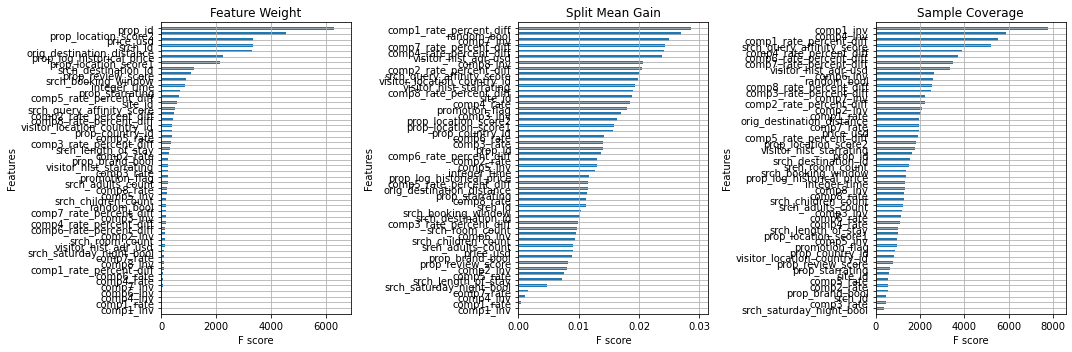

In [18]:
xgc = ranking_model
# saving the feature names to the model
xgc.feature_names = x_train.columns.to_list()
# Create the feature importances plot
fig, ax = plt.subplots(1, 3, figsize=(15,5))
# plot importances with feature weight
xgb.plot_importance(
    booster=xgc, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=xgc,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)
# plot importances with sample coverage
xgb.plot_importance(
    booster=xgc,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)
plt.tight_layout()
plt.show()

Features with almost no weight are useless so can be dropped

In [19]:
#newX = x.drop(['prop_hostel_bool', 'prop_super_region', 'prop_travelad_bool', 'prop_continent', 'prop_dotd_bool', 'srch_mobile_bool', 'srch_device'], axis=1)
newX = x

In [20]:
import xgboost as xgb
from xgboost import DMatrix, train

training_group = newX.groupby(["srch_id"]).size().values
xgb_train = DMatrix(newX, label=y)
xgb_train.set_group(training_group)

evaluation_set = [(xgb_train, 'train')]

In [21]:
%time ranking_model_reduced = train({}, xgb_train, evals=evaluation_set, num_boost_round=100)

[0]	train-rmse:0.36762
[1]	train-rmse:0.27941
[2]	train-rmse:0.22344
[3]	train-rmse:0.18945
[4]	train-rmse:0.16894
[5]	train-rmse:0.15777
[6]	train-rmse:0.15091
[7]	train-rmse:0.14674
[8]	train-rmse:0.14412
[9]	train-rmse:0.14245
[10]	train-rmse:0.14162
[11]	train-rmse:0.14062
[12]	train-rmse:0.13977
[13]	train-rmse:0.13724
[14]	train-rmse:0.13560
[15]	train-rmse:0.13515
[16]	train-rmse:0.13492
[17]	train-rmse:0.13392
[18]	train-rmse:0.13326
[19]	train-rmse:0.13280
[20]	train-rmse:0.13180
[21]	train-rmse:0.13087
[22]	train-rmse:0.12952
[23]	train-rmse:0.12856
[24]	train-rmse:0.12706
[25]	train-rmse:0.12632
[26]	train-rmse:0.12597
[27]	train-rmse:0.12529
[28]	train-rmse:0.12466
[29]	train-rmse:0.12383
[30]	train-rmse:0.12362
[31]	train-rmse:0.12283
[32]	train-rmse:0.12211
[33]	train-rmse:0.12060
[34]	train-rmse:0.12041
[35]	train-rmse:0.12011
[36]	train-rmse:0.11885
[37]	train-rmse:0.11826
[38]	train-rmse:0.11759
[39]	train-rmse:0.11660
[40]	train-rmse:0.11556
[41]	train-rmse:0.11475
[4

In [22]:
%time ranking_model_reduced = train({}, xgb_train, evals=evaluation_set, num_boost_round=10, xgb_model=ranking_model_reduced)

[0]	train-rmse:0.07584
[1]	train-rmse:0.07539
[2]	train-rmse:0.07438
[3]	train-rmse:0.07414
[4]	train-rmse:0.07320
[5]	train-rmse:0.07295
[6]	train-rmse:0.07227
[7]	train-rmse:0.07126
[8]	train-rmse:0.07032
[9]	train-rmse:0.06952
CPU times: user 196 ms, sys: 4.16 ms, total: 200 ms
Wall time: 172 ms


By reducing the model, a new highscore for AUC of `0.9001` was achieved

In [27]:
# Reduced Model
newTestingData = testingData
mat = DMatrix(newTestingData)
predictions = ranking_model_reduced.predict(mat)
testingNumericData = newTestingData.copy()
testingNumericData['predictions'] = predictions
results = testingNumericData[["srch_id", "prop_id", "predictions"]]

In [28]:
# Previous Model
mat = DMatrix(testingData)
predictions = ranking_model.predict(mat)
testingNumericData = testingData.copy()
testingNumericData['predictions'] = predictions
results = testingNumericData[["srch_id","prop_id", "predictions"]]

In [29]:
results_to_csv = results.sort_values(['srch_id'], ascending=True).groupby(['srch_id'], sort=False).apply(lambda x: x.sort_values(['predictions'], ascending=False)).reset_index(drop=True)

In [31]:
submissions = results_to_csv[["srch_id", "prop_id"]]
submissions.to_csv("./submission2.csv", index=False)